# **Model Training**



## **1. Project Setup**

### 1.1 Import Libraries

In [5]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lcz_classification.config import *
from lcz_classification.util import read_lcz_legend, normalize_arr, prepare_dataset, dataset_stats, dataset_summary
from lcz_classification.dataset import fetch_metadata
from lcz_classification.plots import plot_confusion_matrix, plot_feature_importances
import rioxarray as rio

import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, recall_score,precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import rasterio as r
from lcz_classification.util import merge_rasters, clip_raster
from lcz_classification.util import tiles_from_bbox


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Setup Paths

In [6]:
s2_metadata=fetch_metadata('S2_METADATA')
lcz_legend, color_dict=read_lcz_legend(LCZ_LEGEND_FP)
label_dict=lcz_legend.set_index('class')['name'].to_dict()

study_area=fetch_metadata('STUDY_AREA')
study_area=study_area.to_crs(study_area.estimate_utm_crs())
tiles=tiles_from_bbox(study_area.total_bounds, tile_dims=(2,2))

### Load Data

In [7]:
# Read Feature Layers
SF_FP = f'{SF_PRC}/svf_30m.tif'
# Sentinel-2A Imargery
s2=rio.open_rasterio(S2_FP.replace(".tif","_1.tif"))
attrs=s2.attrs
s2 = s2 / 10000
s2.attrs = attrs
s2_arr = s2.values


shape=s2.shape
s2_ref=s2.sel(band=1)
## URBAN CANOPY PARAMETERS ##
bh=rio.open_rasterio(BH_FP).rio.reproject_match(s2_ref) # Building Height
ch=rio.open_rasterio(CH_FP).rio.reproject_match(s2_ref) # Tree Canopy Height
isf=rio.open_rasterio(IS_FP).rio.reproject_match(s2_ref) # Impervious Surface Fraction
bsf=rio.open_rasterio(BS_FP).rio.reproject_match(s2_ref) # Building Surface Fraction
svf=rio.open_rasterio(SF_FP).rio.reproject_match(s2_ref) # Building Surface Fraction

features=eval(s2.attrs['bands'])
s2_b_filtered=s2_metadata[(s2_metadata.mission == "S2A" )& (s2_metadata.band.isin(features))].set_index('band').loc[features]
features=[f'{r.description} ({b})' for b,r in s2_b_filtered.iterrows()]
features.extend(['Building Height', 'Canopy Height', 'Impervious Surface Fraction', 'Building Surface Fraction', 'Sky View Factor'])

# Prepare Feature Stack
X_data=np.append(s2_arr,bh.fillna(0).values, axis=0)
X_data=np.append(X_data,ch.fillna(0).values, axis=0)
X_data=np.append(X_data,isf.fillna(0).values, axis=0)
X_data=np.append(X_data,bsf.fillna(0).values, axis=0)
X_data=np.append(X_data,svf.fillna(0).values, axis=0)

# Rescale Features
scaler=MinMaxScaler()
X_features= np.array([normalize_arr(x, scaler) for x in X_data])

In [8]:
# Read Train / Test Data
train=rio.open_rasterio(TRAIN_FP).rio.reproject_match(s2_ref) # Local Climate Zones Rasterized (Target Layer)
train_arr=train.values

test=rio.open_rasterio(TEST_FP).rio.reproject_match(s2_ref)# Local Climate Zones Rasterized (Target Layer)
test_arr=test.values



### Train, Validation and Test Split

In [9]:

def predictor_stack(features):
    return np.stack(features).reshape(features.shape[0],-1).T

train_mask=train_arr[0] > 0
mask_shape=train_mask.shape
y_train=np.int16(train_arr[0][train_mask].reshape(-1))
X_train =  predictor_stack(np.array([X[train_mask] for X in X_features]))

test_mask=test_arr[0] > 0
mask_shape=test_mask.shape
y_test=np.int16(test_arr[0][test_mask].reshape(-1))

X_test =  predictor_stack(np.array([X[test_mask] for X in X_features]))

# Prepare Training Dataset
# X_train, y_train = prepare_dataset(X_features, train,features)


# # Prepare Testing Dataset
# X_test, y_test = prepare_dataset(X_features, test,features)

# Print Summary of Dataset and Classess
train_stats=dataset_stats(X_train, y_train, label_dict)
# val_stats=dataset_stats(X_val, y_val, label_dict)
test_stats=dataset_stats(X_test, y_test, label_dict )
dataset_summary(train_stats, test_stats)
# labels=[label_dict[x] for x in np.int16(np.unique(y))]


============== DATASET SUMMARY ==============
+--------+---------+----------+---------+
| Datset | Samples | Features | Classes |
+--------+---------+----------+---------+
| Train  |  292184 |    14    |    11   |
|  Test  |  54514  |    14    |    11   |
+--------+---------+----------+---------+

============-==== CLASS SUMMARY =================
+--------------------+--------+-------+
|       Class        | Train  |  Test |
+--------------------+--------+-------+
| Compact High-Rise  |  2210  |  557  |
|  Compact Mid-Rise  |  1046  |  914  |
|  Compact Low-Rise  |  9450  |  3966 |
|   Open High-Rise   |  1154  |  203  |
|   Open Mid-Rise    |  644   |  362  |
|   Open Low-Rise    |  5220  |  1917 |
|    Dense trees     |  5795  | 16160 |
|  Scattered trees   |  6561  |  2849 |
|     Low plants     | 26448  | 22403 |
| Bare rock or paved |  3357  |  3025 |
|       Water        | 230299 |  2158 |
+--------------------+--------+-------+


## Train RandomForest Classifier

In [10]:

classes=[label_dict[int(x)] for x in np.unique(y_train)]

# Model Tuning with Grid Search

In [11]:
from sklearn.model_selection import RandomizedSearchCV



In [ ]:
import joblib

MODEL_DIR="../models/"
MODEL_NAME='rf_cv_optimized'
RF_FP=f"{MODEL_DIR}/rf_cv_optimized.joblib"

SEARCH_METHOD = "random"

search_methods=dict(
    random=RandomizedSearchCV,
    grid=GridSearchCV
)



cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [200, 500, 800], #[100, 150, 200, 500]
    'max_features': ['sqrt', 'log2'], #['auto', 'sqrt', 'log2']
    # 'criterion': ['gini', 'entropy'] #['gini', 'entropy']
    'max_depth' : [10, 20, None],
    'min_samples_split' : [2,5,10],
    'class_weight' : ['balanced', 'balanced_subsample' ,None]
}

if os.path.exists(RF_FP):
    print(f'Train Random Forest Classifier found : {RF_FP}: Loading from File')
    # To load the model later
    cl = joblib.load(RF_FP)

    

else:
    print(f'- No Existing Model Found, running grid search with params:')

   
    print(param_grid)

    # Instantiate RandomForestClassifier without Hyperparameters set
    cl = RandomForestClassifier(random_state=42, n_jobs=-1)
    search=search_methods[SEARCH_METHOD]

    search=search(cl, param_grid, scoring='accuracy', cv =cv, verbose=1, n_jobs=-1, return_train_score=True )
    search.fit(X_train,y_train)
    print(f'- Best Parameters:{search.best_params_}')
    cv_results=pd.DataFrame(search.cv_results_)
    cv_results.to_csv(f"../models/{MODEL_NAME}.csv")
    # Retrieve the best estimator from grid search
    cl=search.best_estimator_
    cl.feature_names_in_ = np.array(features) # Set feature names
    cl.classes_ = np.array(features) 

    # Save the trained model
    joblib.dump(cl, RF_FP)


params = cl.get_params()
params

Train Random Forest Classifier found : ../models//rf_model_cv.joblib: Loading from File
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### Test Classification

Mean Train Score
1.0
Mean Test Score
0.97


In [43]:

cl.fit(X_train,y_train)
y_pred=cl.predict(X_test) # Predict on testing set



                    precision    recall  f1-score   support

 Compact High-Rise       0.30      0.64      0.41       557
  Compact Mid-Rise       0.25      0.10      0.14       914
  Compact Low-Rise       0.54      0.67      0.60      3966
    Open High-Rise       0.10      0.17      0.12       203
     Open Mid-Rise       0.28      0.09      0.14       362
     Open Low-Rise       0.52      0.56      0.54      1917
       Dense trees       0.93      0.75      0.83     16160
   Scattered trees       0.63      0.77      0.69      2849
        Low plants       0.86      0.91      0.88     22403
Bare rock or paved       0.69      0.39      0.50      3025
             Water       0.63      1.00      0.77      2158

          accuracy                           0.78     54514
         macro avg       0.52      0.55      0.51     54514
      weighted avg       0.79      0.78      0.77     54514



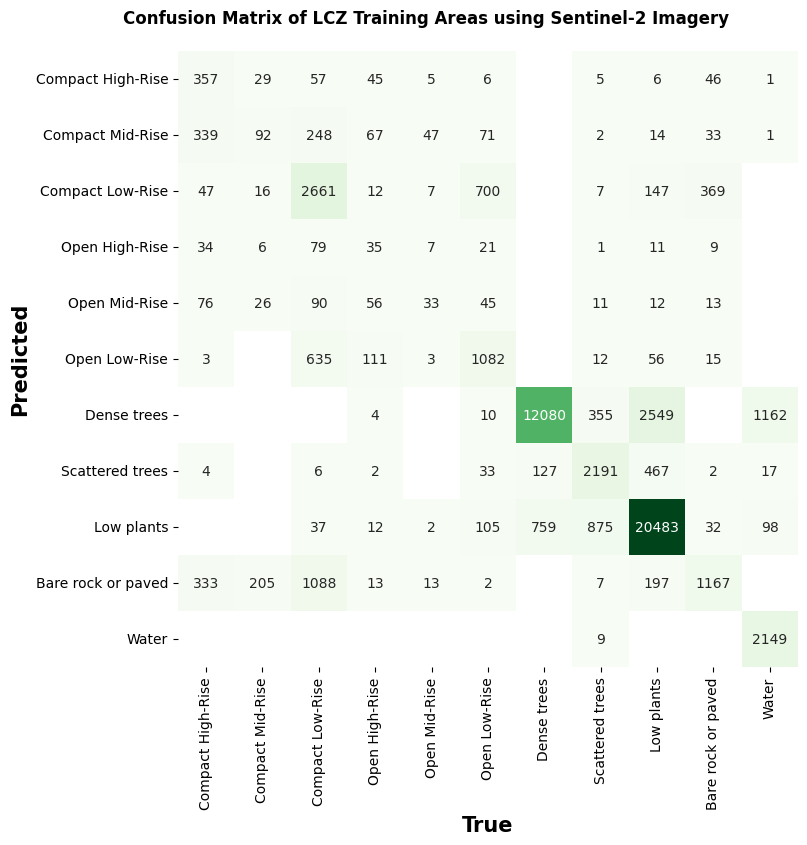

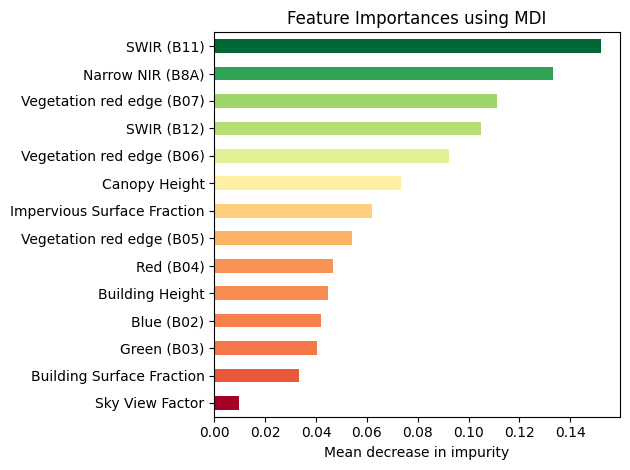

In [ ]:
print('Mean Train Score')
print(cv_results.mean_train_score.mean().round(2))
print('Mean Test Score')
print(cv_results.mean_test_score.mean().round(2))

# Classification Report
cl_report=classification_report(y_test,y_pred,digits=2,target_names=classes)
print(cl_report)


out_file=f"{FIGURES_DIR}/s2_cm.png"

# Confustion Matridx
plot_confusion_matrix(
                    y_test=y_test,
                    y_pred=y_pred,
                    title='Confusion Matrix of LCZ Training Areas using Sentinel-2 Imagery',
                    labels=classes,
                    cmap='Greens', 
                    as_percent=False, 
                    out_file=out_file
                    )


# Feature Importances
out_file=f"{FIGURES_DIR}/s2_fi.png"

plot_feature_importances(cl,features,"Feature Importances using MDI", out_file=out_file)

## Classify LCZs

In [38]:

def masked_features(features, ref, bounds):
    x1,y1,x2,y2 = bounds
    
    mask_raster=ref.sel(x = slice(x1,x2) ,y=slice(y2,y1), drop =False)
    mask_coords=mask_raster.coords
    mask_shape=mask_raster.shape
    mask=((ref.y > y1) & (ref.y < y2) & (ref.x > x1) & (ref.x < x2)).values

    feature_mask=np.array([mask for i in range(0, features.shape[0])])

    masked =  features[feature_mask].reshape(-1, mask_shape[0], mask_shape[1])

    return masked, mask_coords, mask_shape

def predictor_stack(features):
    return np.stack(features).reshape(features.shape[0],-1).T


def classify(cl, predictors, out_shape):
    classified=cl.predict(predictors)
    return classified.reshape(out_shape)

In [45]:



ref=s2.sel(band=1)

for idx, tile in tiles.iterrows():

   
    tile_bounds=tile.geometry.bounds
    tile_id = tile.tile_id

    # Get Reference Masked Raster
    x1,y1,x2,y2 = tile_bounds
    mask_ref = ref.sel(x=slice(x1,x2), y=slice(y2,y1))
    mask_trasnform = mask_ref.rio.transform()

    # Mask predictors
    masked, mask_coords, mask_shape = masked_features(X_features, ref, tile_bounds)
    
    # ## Predict Class on whole dataset
    X_predictors = predictor_stack(masked)
    print(f"Predicting RandomForest Classifier on whole dataset size: {X_predictors.shape[0]:,} pixels")

    classified=classify(cl, X_predictors, mask_shape)
    smooth=median_filter(classified, size=(3,3)) # Remove "Salt and Pepper" effect
    smooth=smooth.reshape(1, mask_shape[0], mask_shape[1])

    out_file=f'../data/toronto/processed/classification/{tile_id}_{CELL_RESOLUTION}m.tif'

    with r.open(
        out_file,
        mode="w",
        transform=mask_trasnform,
        height=mask_shape[0],
        width=mask_shape[1],
        count=1,
        dtype=np.int16,
        crs=s2.rio.crs,
        drive="GTiff",
    ) as predicted:
        predicted.write(smooth)


Predicting RandomForest Classifier on whole dataset size: 6,961,640 pixels
Predicting RandomForest Classifier on whole dataset size: 6,961,640 pixels
Predicting RandomForest Classifier on whole dataset size: 6,964,272 pixels
Predicting RandomForest Classifier on whole dataset size: 6,964,272 pixels


In [48]:


cl_dir=f"../data/toronto/processed/classification"
cl_images=[f"{cl_dir}/{x}" for x in os.listdir(cl_dir) if '.tif' in x]
cl_path=f"{cl_dir}/classified_{CELL_RESOLUTION}m_1.tif"

merge_rasters(raster_paths=cl_images,
              out_path=cl_path,
              transform = s2.rio.transform()
              )

In [49]:
cl_merged=rio.open_rasterio(cl_path)
cl_clipped=cl_merged.rio.clip(list(study_area.geometry.values), drop=True)

In [50]:
clip_raster(
    raster_path=cl_path,
    gdf=study_area,
    bbox=None,
    out_path=cl_path.replace(".tif", 'clip.tif'), 
)

Clipped classified_30m_1.tif
Exported clipped raster for classified_30m_1.tif
